In [62]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Preprocessing

## Data

In [63]:
raw_df = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv')
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3020 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3020 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3020 non-null   float64       
 5   Volume  3020 non-null   int64         
 6   Name    3020 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.3+ KB


In [64]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
train_df = raw_df[raw_df['Date'] < '2017-01-01']
val_df = raw_df[raw_df['Date'] >= '2017-01-01']
train_df.describe()

,Date,Open,High,Low,Close,Volume
count,2769,2769.000000,2769.000000,2769.000000,2769.000000,2.769000e+03
mean,2011-07-03 12:59:32.697724928,144.407172,145.608797,143.347790,144.525677,5.911017e+06
min,2006-01-03 00:00:00,72.740000,73.940000,69.500000,71.740000,1.397455e+06
25%,2008-10-02 00:00:00,113.840000,115.010000,112.260000,113.940000,3.740884e+06
50%,2011-07-01 00:00:00,146.020000,147.300000,145.250000,146.480000,5.090345e+06
75%,2014-04-03 00:00:00,181.660000,182.910000,180.220000,181.690000,7.134982e+06
max,2016-12-30 00:00:00,215.380000,215.900000,214.300000,215.800000,3.077428e+07
std,NaN,38.856172,38.933205,38.771873,38.839850,3.208030e+06


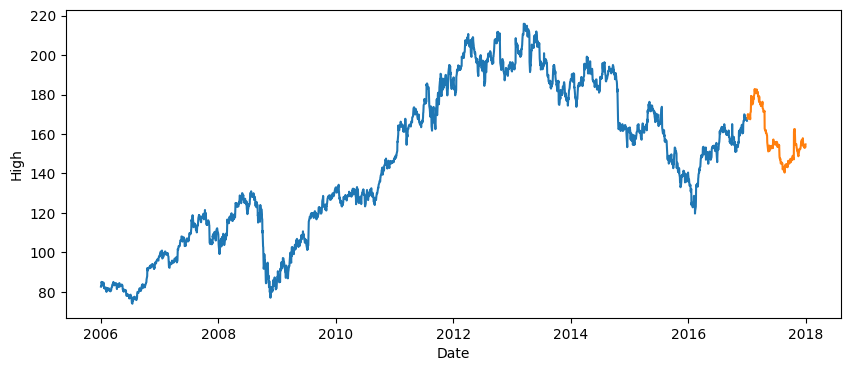

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(data=train_df, x='Date', y='High', ax=ax)
sns.lineplot(data=val_df, x='Date', y='High', ax=ax);

## Scaler

In [66]:
train_price_df = train_df[['High']]
val_price_df = val_df[['High']]
raw_price_df = raw_df[['High']]

In [107]:
sc = MinMaxScaler()
scaled_df = sc.fit_transform(raw_price_df)
scaled_raw_df = scaled_df
scaled_df = sc.fit_transform(train_price_df)
scaled_train_df = scaled_df
scaled_df = sc.fit_transform(val_price_df)
scaled_val_df = scaled_df

## Data Shape

In [109]:
def transform_data(stock, lookback):
    data_raw = stock
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_train = data[:,:-1,:]
    y_train = data[:,-1,:]
    
    
    return [x_train, y_train]

In [110]:
num_hidden = 60
x_train, y_train = transform_data(scaled_train_df, num_hidden)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
x_val, y_val = transform_data(scaled_val_df, num_hidden)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)

x_train.shape =  (2709, 59, 1)
y_train.shape =  (2709, 1)
x_val.shape =  (191, 59, 1)
y_val.shape =  (191, 1)


In [113]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_val_tensor = torch.from_numpy(x_val).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_val_tensor= torch.from_numpy(y_val).type(torch.Tensor)

print("Shape x_train_tensor:", x_train_tensor.shape)
print("Shape y_train_tensor:", y_train_tensor.shape)
print("Shape x_val_tensor:", x_val_tensor.shape)
print("Shape y_val_tensor:", y_val_tensor.shape)

Shape x_train_tensor: torch.Size([2709, 59, 1])
Shape y_train_tensor: torch.Size([2709, 1])
Shape x_val_tensor: torch.Size([191, 59, 1])
Shape y_val_tensor: torch.Size([191, 1])


# Processing

## Model

In [114]:
class LSTM_Stock(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers):
        super(LSTM_Stock, self).__init__()
        self.hidden_dim = num_hiddens
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(num_inputs, num_hiddens, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(num_hiddens, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
        

In [115]:
model = LSTM_Stock(1, 32, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [116]:
for epoch in range(50):
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{50}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.481232
Epoch [2/50], Loss: 0.328847
Epoch [3/50], Loss: 0.174567
Epoch [4/50], Loss: 0.062205
Epoch [5/50], Loss: 0.234549
Epoch [6/50], Loss: 0.102287
Epoch [7/50], Loss: 0.059061
Epoch [8/50], Loss: 0.079041
Epoch [9/50], Loss: 0.098652
Epoch [10/50], Loss: 0.104099
Epoch [11/50], Loss: 0.098207
Epoch [12/50], Loss: 0.086133
Epoch [13/50], Loss: 0.072688
Epoch [14/50], Loss: 0.061798
Epoch [15/50], Loss: 0.055999
Epoch [16/50], Loss: 0.055854
Epoch [17/50], Loss: 0.059646
Epoch [18/50], Loss: 0.063911
Epoch [19/50], Loss: 0.065244
Epoch [20/50], Loss: 0.062311
Epoch [21/50], Loss: 0.056245
Epoch [22/50], Loss: 0.049385
Epoch [23/50], Loss: 0.043766
Epoch [24/50], Loss: 0.040306
Epoch [25/50], Loss: 0.038599
Epoch [26/50], Loss: 0.036870
Epoch [27/50], Loss: 0.032108
Epoch [28/50], Loss: 0.021165
Epoch [29/50], Loss: 0.006070
Epoch [30/50], Loss: 0.007402
Epoch [31/50], Loss: 0.017666
Epoch [32/50], Loss: 0.013429
Epoch [33/50], Loss: 0.006883
Epoch [34/50], Loss

## Visualization and testing

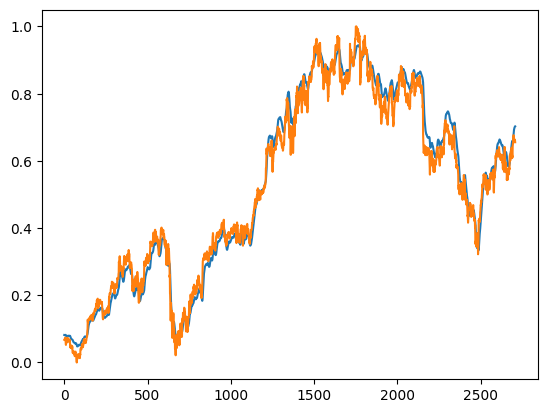

In [119]:
train_preds = model(x_train_tensor).detach().numpy()
plt.plot(train_preds)
plt.plot(y_train);

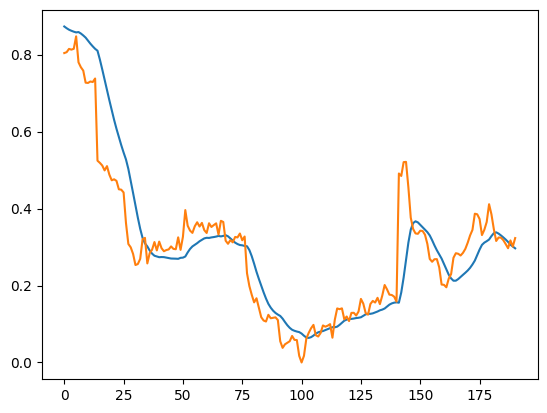

In [120]:
y_preds = model(x_val_tensor).detach().numpy()
plt.plot(y_preds)
plt.plot(y_val);